In [2]:
import pandas as pd
import h5py
import numpy as np
from scipy.signal import convolve2d
from scipy.stats.stats import pearsonr
import weblogo
import seqlogo
import matplotlib as mpl
from matplotlib import pyplot as plt 
from keras.models import load_model
import os

Using TensorFlow backend.


In [3]:
#fn= file where model weights hdf5 is located
#layer= the layer number or layer name to be opend ; e.g. to open the first layer in model, set layer = 0 
def getWandB(fn,layer):
    model = load_model(fn)
    dataW=model.layers[layer].get_weights()[0][...]
    dataB=model.layers[layer].get_weights()[1][...]
    return dataW, dataB


    

In [4]:
#weights is same as dataW output from getWandB() function 
def getFilters (weights):  
    dims=weights.shape
    full=[]
    for fth in range(dims[3]):
        fltr=[]
        for fst in range(dims[0]):
            baseRow=[]
            for snd in range(dims[1]):
                baseRow.append(weights[fst,snd,0,fth])
            fltr.append(baseRow)
        full.append(fltr)
    fltrs=np.array(full)
    return fltrs

In [5]:
#numbRandSeqs, is the number of random sequences to be scored against filters 
    #(to be used to make seqlogo in next step), ("paper used 488,000")
#flrh is filter height (4 for 4 bases in all cases using just primary sequence), 
#fltrw is filter width (should be 13 in this case, but if hyperparameter optization gets different result maybe another)
    #you can check the size by just taking a fltr and getting its dimensions and taking the second number given
def getRandSeqs(numbRandSeqs,fltrh,fltrw):
    randMtxs=[]
    for n in range(0,numbRandSeqs):
        randSet=np.random.randint(0,fltrh,fltrw)
        randMtx=np.matrix(np.zeros((fltrh,fltrw)))
        for i in range(len(randSet)):
            randMtx[randSet[i],i] = 1
        randMtxs.append(randMtx)
    return randMtxs

In [6]:
#fltrs is output from getFilters function
#numbHighScores is the number of scores taken from scoring the random sequences to the filters, to be used ...
    #to create sequence logo (this number is 1000 in paper; 1000 from the 488,000 sequences for each filter)
#folder is name to place seqlogos 
#DO NOT NEED TO ADD BIAS since THE SCORE ITSELF IS NOT IMPORTANT JUST THE ORDERING OF THE SCORES !!!
def getSeqLogosandPWMs(fltrs,numbHighScores,folder): 
    if not os.path.exists(folder): os.mkdir(folder)
    PPMs=[]
    #PWMs=[]
    for i in range(len(fltrs)):
        fltrMtx=np.matrix(fltrs[i])
        bi=bias[i]
        hght=fltrMtx.shape[0]
        wth=fltrMtx.shape[1]
        shapeDims=hght*wth 
        scores=[]
        for randMtx in randMtxs:
            score= convolve2d(fltrMtx,randMtx,'valid')#/shapeDims + bi
            scores.append(score.item())
        scores=pd.Series(scores)    
        highScores=scores.sort_values(ascending=False)[:numbHighScores]
        PFM=np.matrix(np.zeros([hght,wth]))
        for hsi in highScores.index:
            PFM=PFM + randMtxs[hsi]
        PPM=seqlogo.Ppm(PFM/numbHighScores)  
        #assume equal likelihood of each base at each positions (0.25) in PPM to PWM conversion 
        with np.errstate(divide='ignore'):
            #PWM=np.log2(PPM/0.25)
            #PWM=seqlogo.ppm2pwm(PPM)
            fltrName= folder + "/filter" + str(i) + '.png'
            seqlogo.seqlogo(PPM, ic_scale = True, format = 'png', size = 'medium', filename= fltrName)
        #PWMs.append(PWM)
        PPMs.append(PPM)
    return PPMs #,PWMs 

In [7]:
#UTRcsvfn is filename for UTR csv file
#seq_column is column number or name that has sequences
#expression is column number or name that has expression data (growth rates in this case)

def one_hot_encoding(UTRcsvfn, seq_column, expression):
    df = pd.read_csv(UTRcsvfn)
    bases = ['A','C','G','T']
    base_dict = dict(zip(bases,range(4))) # {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}

    n = len(df)
    
    # length of the UTR sequence
    # we also add 10 empty spaces to either side
    total_width = df[seq_column].str.len().max() + 20
    
    # initialize an empty numpy ndarray of the appropriate size
    X = np.zeros((n, 1, 4, total_width))
    
    # an array with the sequences that we will one-hot encode
    seqs = df[seq_column].values
    
    # loop through the array of sequences to create an array that keras will actually read
    for i in range(n):
        seq = seqs[i]
        
        # loop through each individual sequence, from the 5' to 3' end
        for b in range(len(seq)):
            # this will assign a 1 to the appropriate base and position for this UTR sequence
            X[i, 0, base_dict[seq[b]], int(b + round((total_width - len(seq))/2.))] = 1.
    
        # keep track of where we are
        if (i%10000)==0:
            print(str(i)+",")
        
    #X = X.astype(theano.config.floatX)
    X = X.astype('float32')
    Y = np.asarray(df[expression].values,
                   dtype = 'float32')[:, np.newaxis]
    
    return X, Y, total_width


In [8]:
#SHOULD I ADD BIAS TO CONVOLUTION VALUE? BIAS ADDITION WILL BE THE SAME FOR WITHIN EACH FILTER, BUT ADDING THIS ...
    #VALUE WILL SLIGHTLY CHANGE THE PEARSON CORRELATION
    #SOLUTION: check bias values and see how much it is going to effect scores and pearson correlation in general
def fltrEnrichCorr(X,Y,fltrs):
    corrs=[]
    Y=[ary[0] for ary in Y]
    for i in range(len(fltrs)):
        fltr=fltrs[i]
        maxConvs=[]
        for seq in X:
            maxConv = convolve2d(seq[0],fltr,'valid').max()
            maxConvs.append(maxConv)
        corr = pearsonr(maxConvs,Y)[0]
        corrs.append(corr)
    return corrs

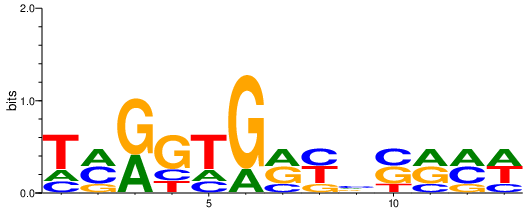

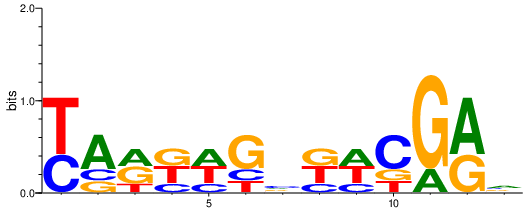

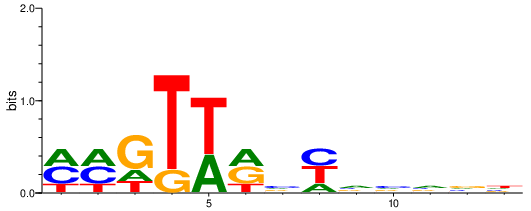

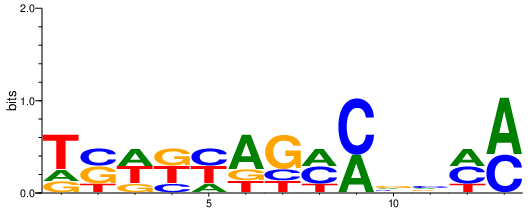

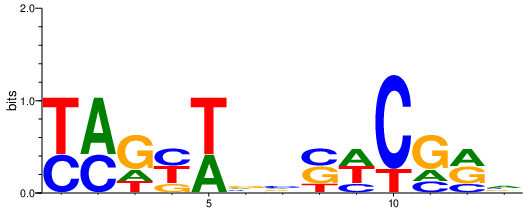

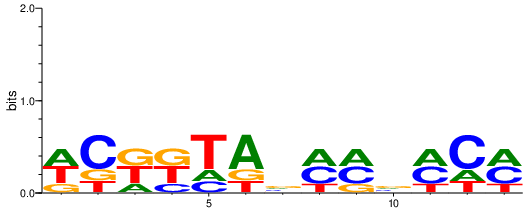

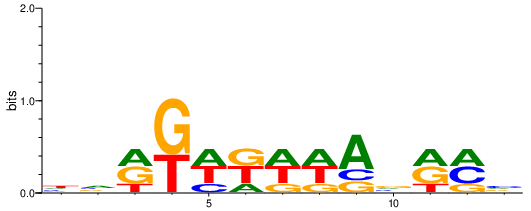

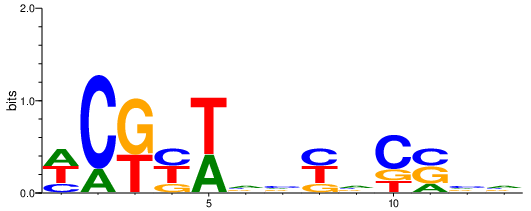

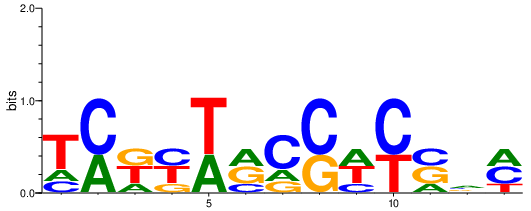

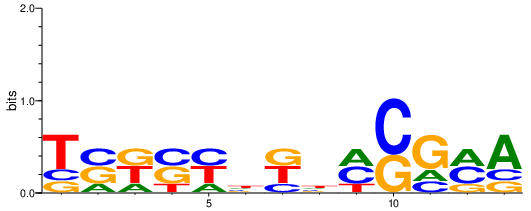

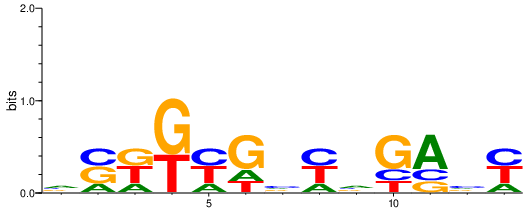

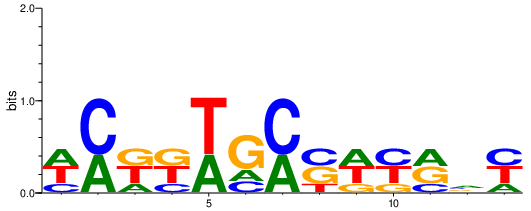

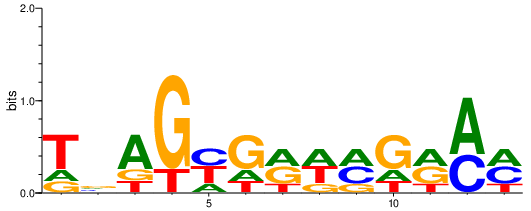

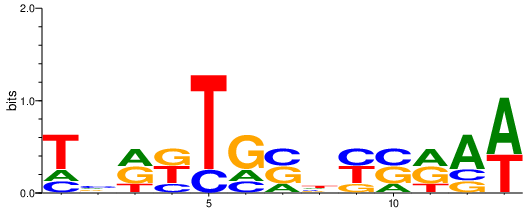

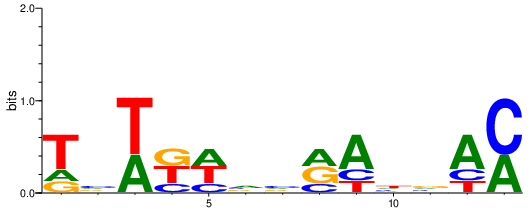

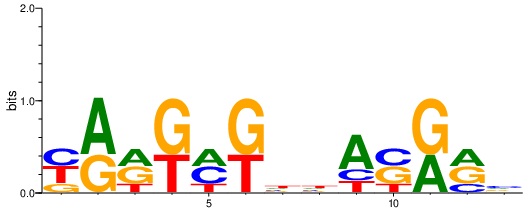

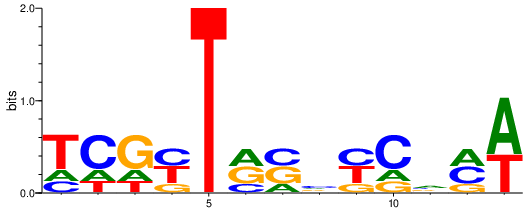

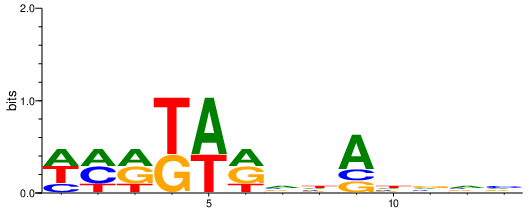

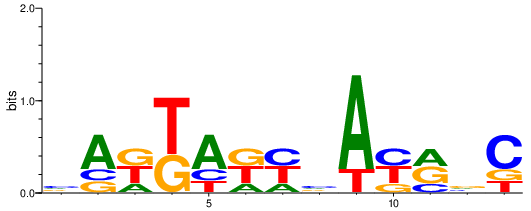

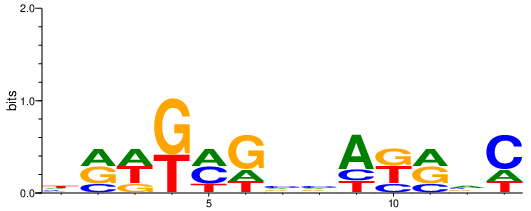

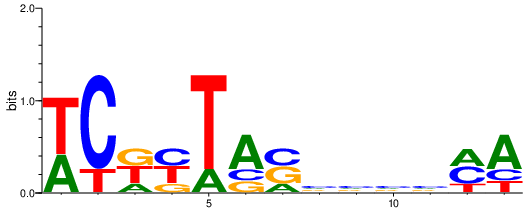

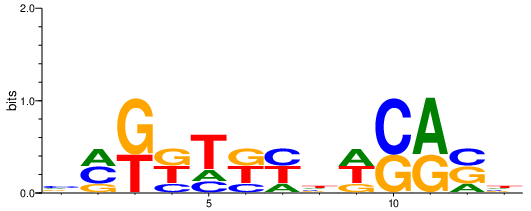

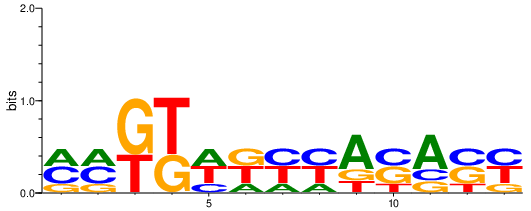

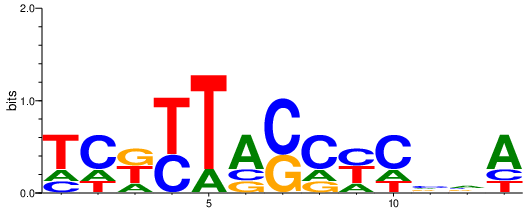

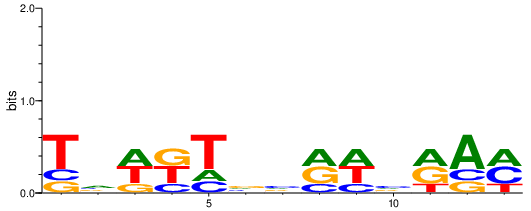

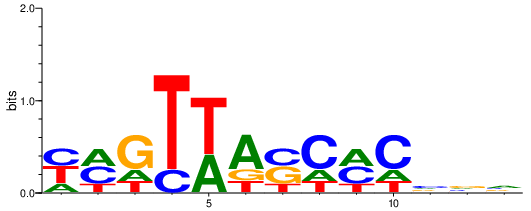

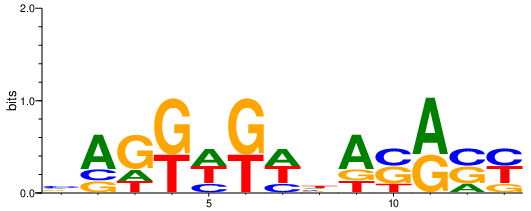

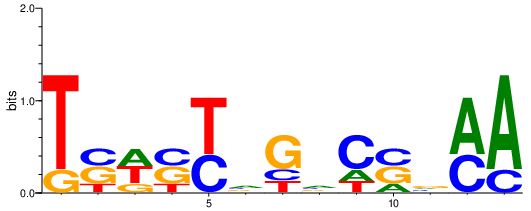

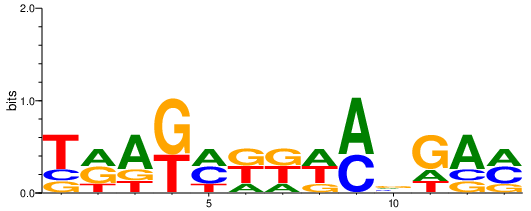

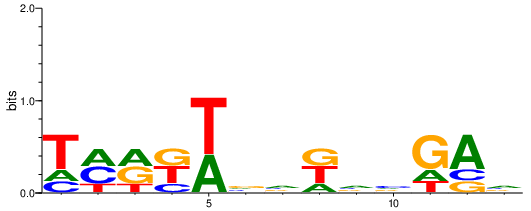

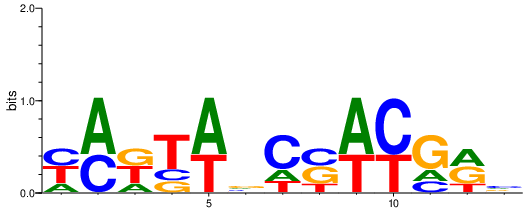

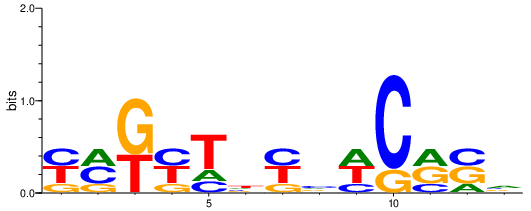

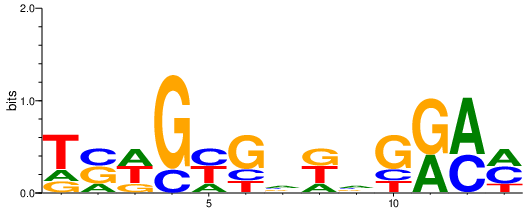

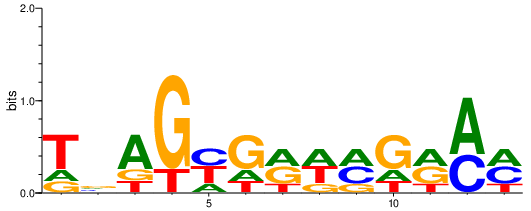

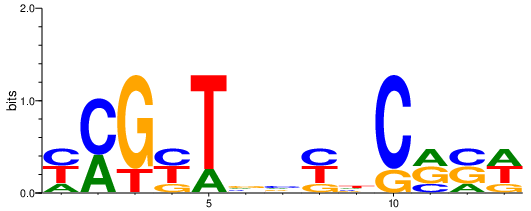

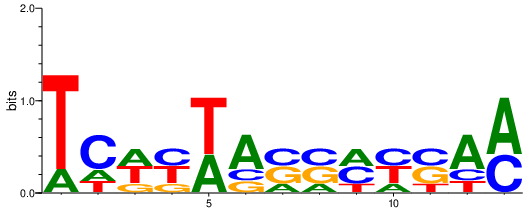

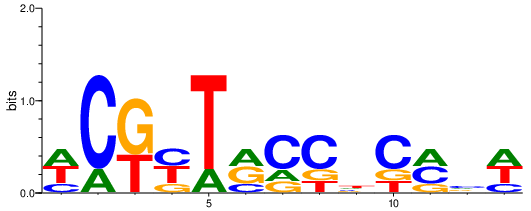

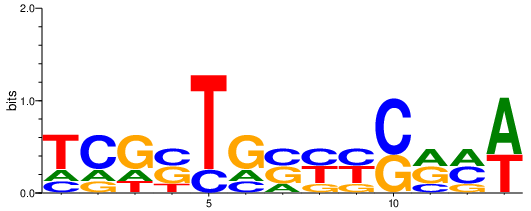

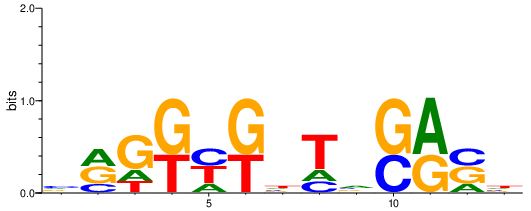

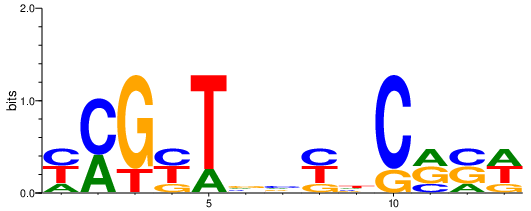

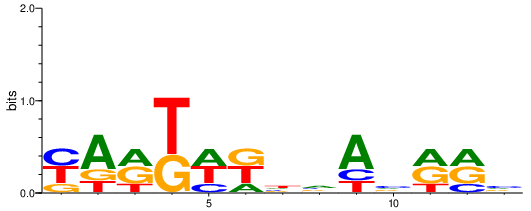

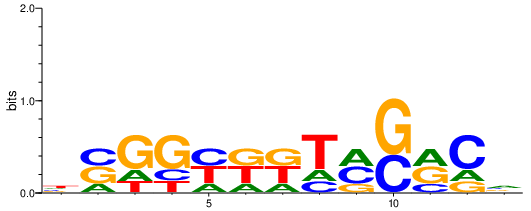

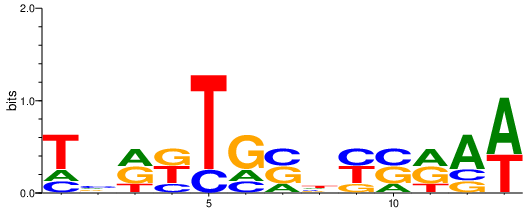

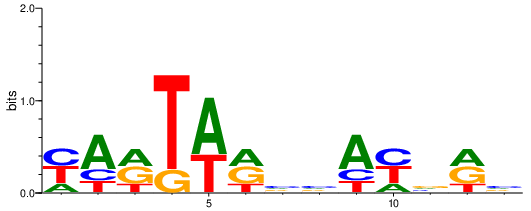

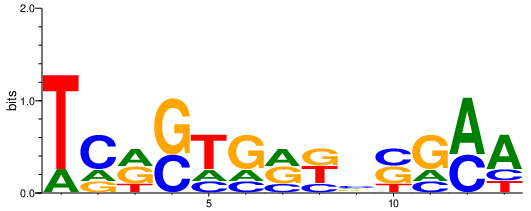

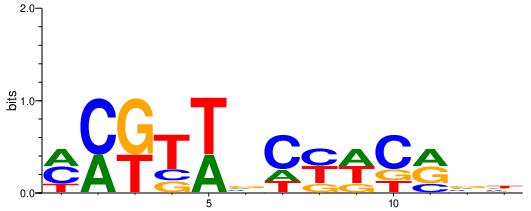

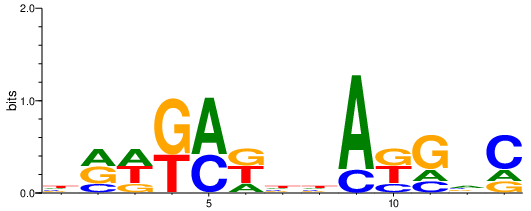

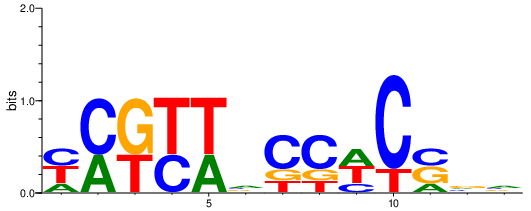

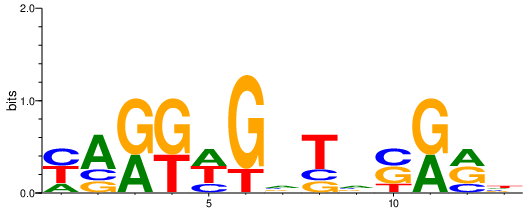

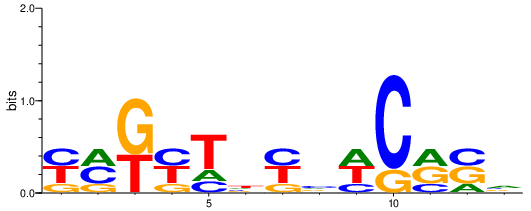

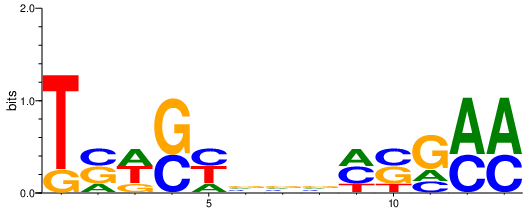

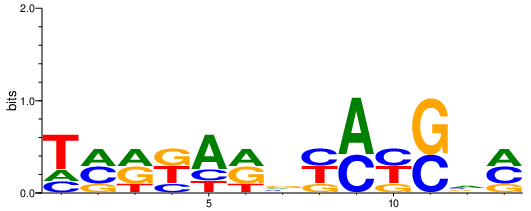

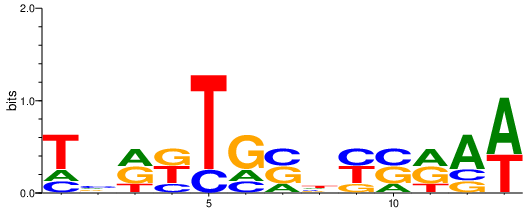

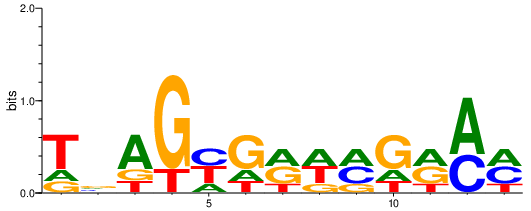

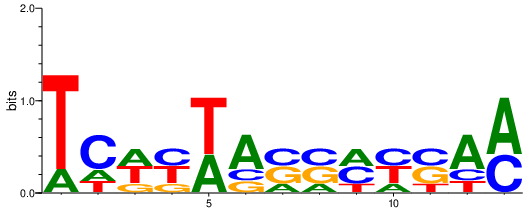

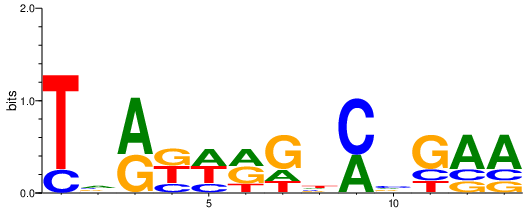

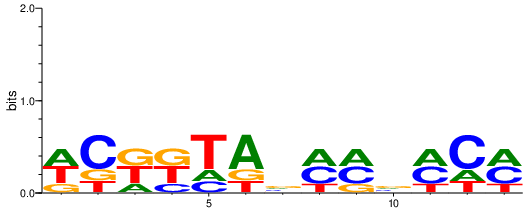

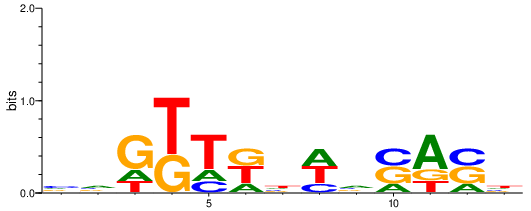

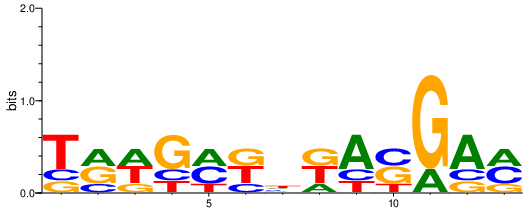

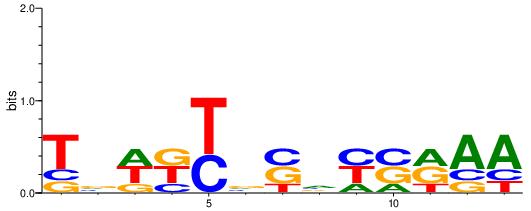

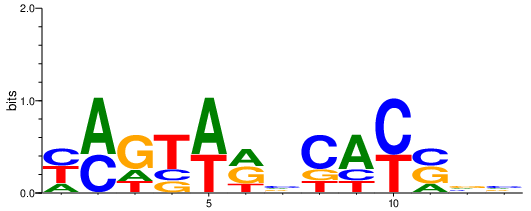

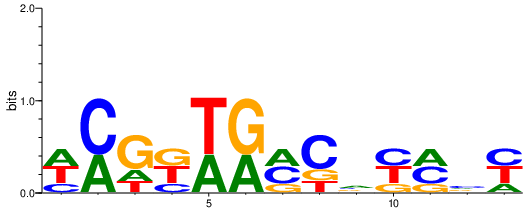

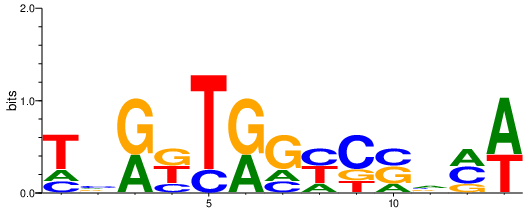

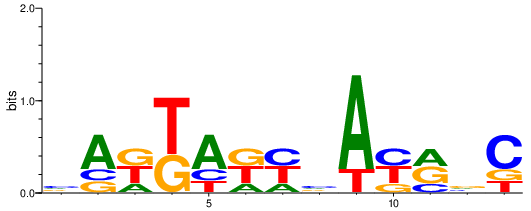

0,


In [35]:
fn='/Users/harrys/Documents/CuperusR/Results/Random_UTR_CNN.Hyperparam.Opt/model_weights.hdf5'
#fn="../Downloads/CuperusR/Results/Random_UTR_CNN.Hyperparam.Opt/model_weights.hdf5"
weights,bias = getWandB(fn,0)
fltrs=getFilters(weights)
randMtxs=getRandSeqs(10,4,13)
PPMs=getSeqLogosandPWMs(fltrs,5,"../Downloads/testSeqLogos")
X,Y,total_width = one_hot_encoding('CuperusR/Data/Random_UTRsSUB.csv',"UTR","growth_rate")
corrs = fltrEnrichCorr(X,Y,fltrs)
with open('../Downloads/Correlations.txt', 'w') as cf:
    for item in corrs:
        cf.write("%s\n" % item)
        